# 一、回归问题的K近邻法
K近邻估计量（K nearest neighbor estimator）以离$x$最近的K个邻居的y观测值的平均作为预测值：
$$\hat f_{KNN}(x)=\frac{1}{K}\sum_{x_i\in N_K(x)}{y_i}$$
使用前提：
1. 所有特征变量均为数值型，以计算欧式距离。
2. 将所有变量标准化，以避免某些变量对于距离函数的影响太大。

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor

In [2]:
data=pd.read_csv('/Users/singal/Desktop/MLPython_Data/mcycle.csv')
data.shape

(133, 2)

In [3]:
data.head()

,times,accel
0,2.4,0.0
1,2.6,-1.3
2,3.2,-2.7
3,3.6,0.0
4,4.0,-2.7


Text(0, 0.5, 'accel')

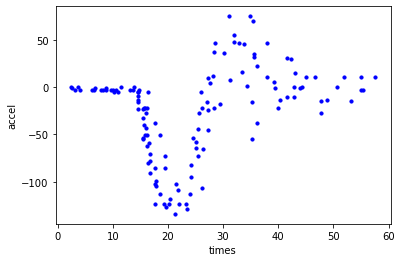

In [4]:
plt.scatter(x=data.times,y=data.accel,c='b',s=10)
plt.xlabel('times')
plt.ylabel('accel')

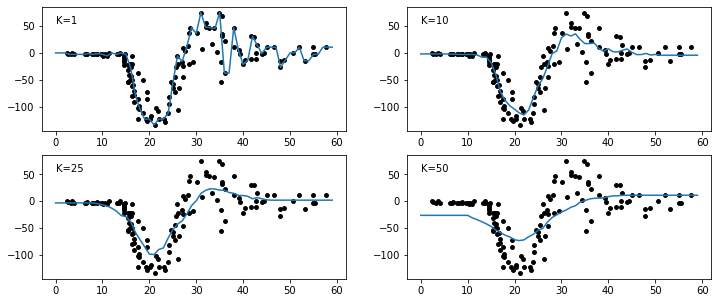

In [5]:
x=np.array(data.times).reshape(-1,1)
y=data.accel
plt.figure(figsize=(12,5))
for i,k in zip([1,2,3,4],[1,10,25,50]):
    model=KNeighborsRegressor(n_neighbors=k)
    model.fit(x,y)
    pred=model.predict(np.arange(60).reshape(-1,1))
    plt.subplot(2,2,i)
    plt.scatter(x,y,c='k',s=15)
    plt.plot(np.arange(60),pred)
    plt.text(0,55,f'K={k}')

结果显示：
1. K=1时，即最近邻法存在过拟合，回归函数非常不光滑，训练误差很小。
2. K=10时，回归函数虽然不太光滑，但较好的抓住了数据特征，拟合程度比较合适。
3. K=25时，回归函数较光滑，但无法较好地展示数据特征，拟合程度较差。
4. K=50时，回归函数最光滑，但无法反映数据特征，拟合程度最差。
5. 在K增大的过程中，偏差依次增大，方差依次减小。

# 二、分类问题的K近邻法
采用**多数票规则**，即以K个近邻中出现次数最多的类别作为预测。

In [6]:
from sklearn.datasets import load_iris
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.plotting import plot_decision_regions

In [7]:
X,y=load_iris(return_X_y=True)
X2=X[:,2:4]

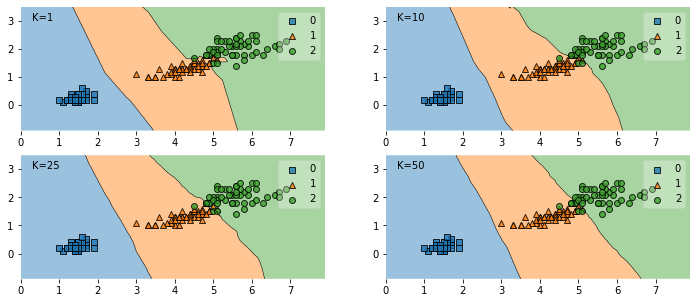

In [8]:
plt.figure(figsize=(12,5))
for i,k in zip([1,2,3,4],[1,10,25,50]):
    model=KNeighborsClassifier(n_neighbors=k)
    model.fit(X2,y)
    plt.subplot(2,2,i)
    plot_decision_regions(X2,y,model)
    plt.text(0.3,3,'K={}'.format(k))

随着K增大，KNN决策边界越来越光滑，可能导致欠拟合，而K过小，则可能导致过拟合。
# 三、K近邻法的完整案例

In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split,GridSearchCV,StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_breast_cancer

## 1、数据处理和分析

array是数值数组，不能包含字符串，故先将array转化为数据框，再进行赋值。

In [10]:
data=load_breast_cancer()
X=pd.DataFrame(data.data,columns=data.feature_names)
y=data.target
y_names=pd.DataFrame(np.zeros(len(y)))
for i in range(len(y)):
    if y[i]==0:
        y_names.iloc[i,0]='malignant'
    else:
        y_names.iloc[i,0]='benign'
y_names.value_counts()#观察响应变量的分布状况

benign       357
malignant    212
dtype: int64

<AxesSubplot:xlabel='0', ylabel='mean radius'>

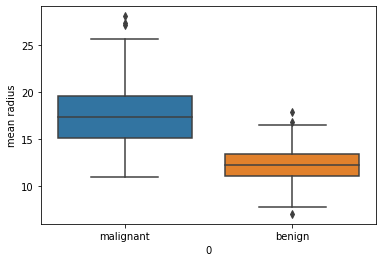

In [11]:
sns.boxplot(x=y_names.iloc[:,0],y=X['mean radius'])#对于箱型图，一般横着为类别，纵轴为比较的指标

结果显示，恶性肿瘤的细胞核半径明显大于良性肿瘤。
## 2、K邻居法估计
注意：在标准化测试集时，不能使用测试集的信息，即不能使用测试集的均值和标准差，以免“提前泄露测试集的信息”。故标准化测试集时，只能使用训练集的信息。

In [12]:
xtrain,xtest,ytrain,ytest=train_test_split(X,y,stratify=y,test_size=100,random_state=1)
scaler=StandardScaler()#需将数据矩阵标准化
scaler.fit(xtrain)
xtrain=scaler.transform(xtrain)
xtest=scaler.transform(xtest)

In [13]:
model=KNeighborsClassifier(n_neighbors=5)
model.fit(xtrain,ytrain)
print('训练集预测准确率为：',model.score(xtrain,ytrain))
print('测试集预测准确率为：',model.score(xtest,ytest))

训练集预测准确率为： 0.9786780383795309
测试集预测准确率为： 0.97


## 3、考察超参数K
手动考察超参数，但此方法通过测试集选择K，相当于“泄露”了测试集的信息，可能低估了测试误差。

In [14]:
scores=[]
ks=range(1,51)
for k in ks:
    model=KNeighborsClassifier(n_neighbors=k)
    model.fit(xtrain,ytrain)
    scores.append(model.score(xtest,ytest))

In [15]:
scores=np.array(scores)#list对象无argmax方法
index_max=scores.argmax()
print(f'最优邻居数K为：{ks[index_max]}')

最优邻居数K为：3


Text(0.5, 1.0, 'KNN')

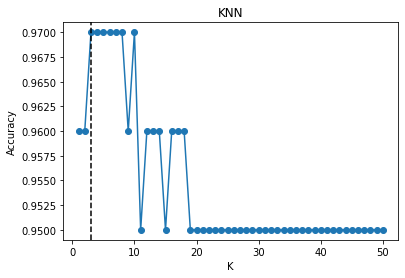

In [16]:
plt.plot(ks,scores)
plt.scatter(ks,scores)
plt.axvline(ks[index_max],linestyle='--',color='k')
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.title('KNN')

通过交叉验证选择最优超参数K。
注意：GridSearchCV类要求param_grid是dict（or list of dicts），其中key为str，values为list，且str必须对应估计量参数的名称，如“n_neighbors”。

In [17]:
param_grid={'n_neighbors':range(1,51)}
kfold=StratifiedKFold(n_splits=10,shuffle=True,random_state=1)
model=GridSearchCV(KNeighborsClassifier(),param_grid=param_grid,cv=kfold)
model.fit(xtrain,ytrain)
print('最优参数K为：',model.best_params_)
print('训练集最高准确率：',model.best_score_)

最优参数K为： {'n_neighbors': 12}
训练集最高准确率： 0.9744218316373727


多分类模型评估四板斧：
1. confusion_matrix
2. classification_report
3. cohen_kappa_score
4. plot_roc_curve

In [18]:
from sklearn.metrics import confusion_matrix,cohen_kappa_score,classification_report,plot_roc_curve


In [19]:
pred=model.predict(xtest)
prob=model.predict_proba(xtest)
print('混淆矩阵：\n',confusion_matrix(ytest,pred))
print('科恩的kappa指标：\n',cohen_kappa_score(ytest,pred))
print('报告：\n',classification_report(ytest,pred))

混淆矩阵：
 [[33  4]
 [ 0 63]]
科恩的kappa指标：
 0.9122422114962703
报告：
               precision    recall  f1-score   support

           0       1.00      0.89      0.94        37
           1       0.94      1.00      0.97        63

    accuracy                           0.96       100
   macro avg       0.97      0.95      0.96       100
weighted avg       0.96      0.96      0.96       100



Text(0.5, 1.0, 'ROC Curve for K Nearest Neighbor')

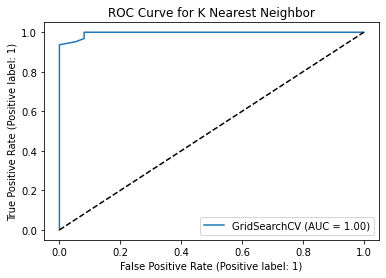

In [20]:
plot_roc_curve(model,xtest,ytest)
x=np.linspace(0,1,100)
plt.plot(x,x,'--k')
plt.title('ROC Curve for K Nearest Neighbor')